Selected image from dataset/motion/testuhdm/blurry: dataset/motion/testuhdm/blurry/6_ours_20200903IMG_1147_t1_151.png
Selected image from dataset/motion/testuhdm/sharp: dataset/motion/testuhdm/sharp/6_ours_20200903IMG_1147_151.png
Model images loaded: ['results/motion/testuhdm/best_new_model_testuhdm/all/6_ours_20200903IMG_1147_t1_171_PSNR17.53_SSIM0.40_MAE0.10_LPIPS0.53_DeltaE6.14.png', 'results/motion/testuhdm/finetunedwithJ_testuhdm/all/6_ours_20200903IMG_1147_t1_171_PSNR16.97_SSIM0.36_MAE0.11_LPIPS0.57_DeltaE6.86.png', 'results/motion/testuhdm/finetunedwithR_testuhdm/all/6_ours_20200903IMG_1147_t1_171_PSNR17.31_SSIM0.35_MAE0.10_LPIPS0.59_DeltaE6.32.png', 'results/motion/testuhdm/motion_deblurring_testuhdm/all/6_ours_20200903IMG_1147_t1_171_PSNR16.58_SSIM0.30_MAE0.11_LPIPS0.67_DeltaE5.89.png', 'results/motion/testuhdm/trained_from_scratch_testuhdm/all/6_ours_20200903IMG_1147_t1_171_PSNR17.19_SSIM0.35_MAE0.11_LPIPS0.60_DeltaE6.10.png']
Blurry image path: dataset/motion/testuhdm/blurr

/home/user1/miniconda3/envs/pytorch181/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


Random zoom coordinates: (736, 31, 836, 131)


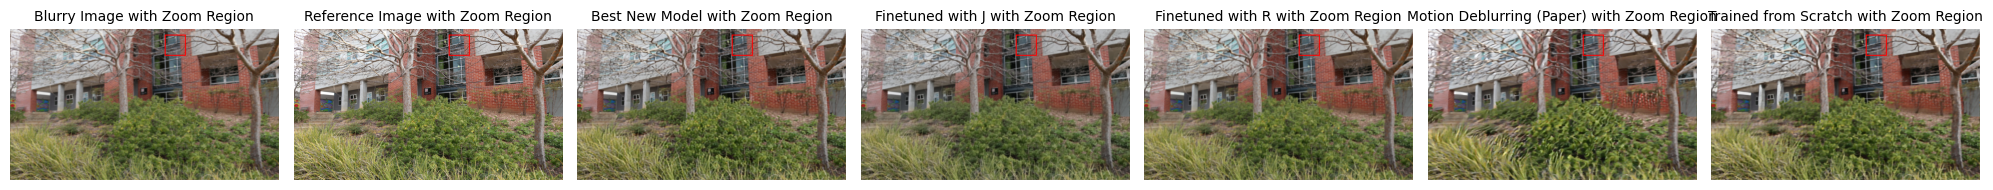

Extracted PSNR from 6_ours_20200903IMG_1147_t1_171_PSNR17.53_SSIM0.40_MAE0.10_LPIPS0.53_DeltaE6.14.png: PSNR: 17.53
Extracted PSNR from 6_ours_20200903IMG_1147_t1_171_PSNR16.97_SSIM0.36_MAE0.11_LPIPS0.57_DeltaE6.86.png: PSNR: 16.97
Extracted PSNR from 6_ours_20200903IMG_1147_t1_171_PSNR17.31_SSIM0.35_MAE0.10_LPIPS0.59_DeltaE6.32.png: PSNR: 17.31
Extracted PSNR from 6_ours_20200903IMG_1147_t1_171_PSNR16.58_SSIM0.30_MAE0.11_LPIPS0.67_DeltaE5.89.png: PSNR: 16.58
Extracted PSNR from 6_ours_20200903IMG_1147_t1_171_PSNR17.19_SSIM0.35_MAE0.11_LPIPS0.60_DeltaE6.10.png: PSNR: 17.19


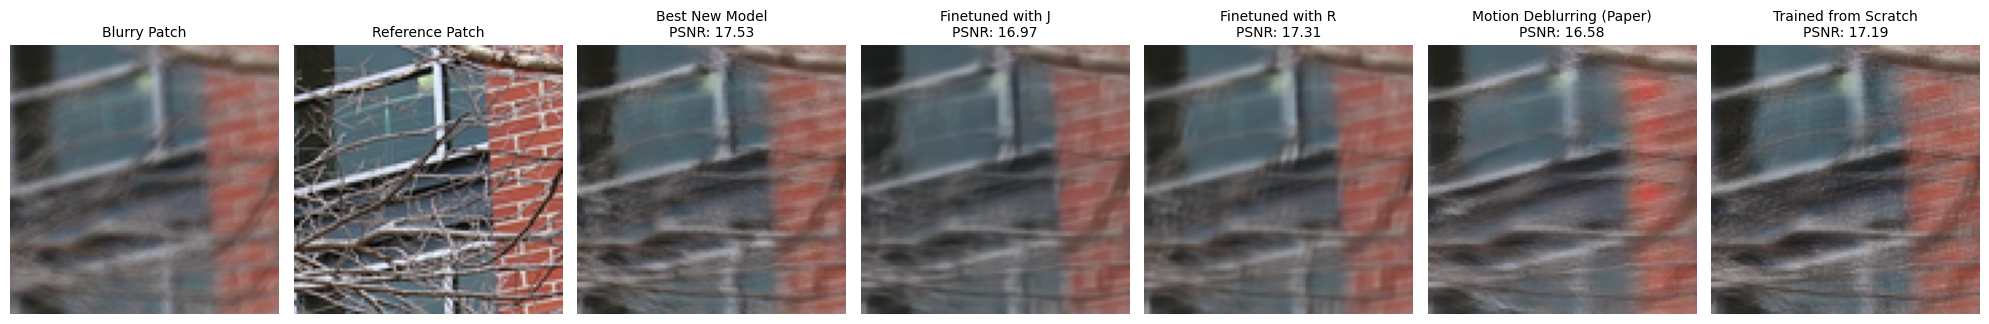

In [68]:
import os
import random
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def load_images_from_all(model_folders, order=2):
    """
    Load the n-th ordered image from the 'all' folder inside each model folder.
    Assumes a consistent directory structure.
    
    Parameters:
    - model_folders: List of model folders.
    - order: The n-th index of the sorted images to pick (default: 2).
    """
    images = []
    for folder in model_folders:
        all_folder = os.path.join(folder, "all")
        # Get all image files in the "all" folder
        image_files = sorted([f for f in os.listdir(all_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
        
        if image_files:
            if 0 <= order < len(image_files):  # Check if the order index is valid
                selected_image = image_files[order]
            else:
                raise IndexError(f"Order {order} is out of range for the available files in {all_folder}")
            images.append(os.path.join(all_folder, selected_image))
        else:
            raise FileNotFoundError(f"No images found in {all_folder}")
    print(f"Model images loaded: {images}")  # Log the model paths
    return images

def get_nth_image_from_directory(directory, order=2):
    """
    Select the n-th ordered image from a directory.
    """
    image_files = sorted([f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))])
    if image_files:
        if 0 <= order < len(image_files):  # Check if the order index is valid
            selected_image_path = os.path.join(directory, image_files[order])
            print(f"Selected image from {directory}: {selected_image_path}")  # Log the path
            return selected_image_path
        else:
            raise IndexError(f"Order {order} is out of range for the available files in {directory}")
    else:
        raise FileNotFoundError(f"No images found in {directory}")

def resize_image(image, target_size=(1280, 720)):
    """
    Resize an image to the specified target size.
    """
    return image.resize(target_size, Image.ANTIALIAS)

def get_random_zoom_coords(image_size, box_size=100):
    """
    Generate random coordinates for a zoom box within the image boundaries.
    """
    width, height = image_size
    x1 = random.randint(0, width - box_size)
    y1 = random.randint(0, height - box_size)
    x2 = x1 + box_size
    y2 = y1 + box_size
    zoom_coords = (x1, y1, x2, y2)
    print(f"Random zoom coordinates: {zoom_coords}")  # Log the zoom coordinates
    return zoom_coords

def extract_psnr_from_filename(filename):
    """
    Extract the PSNR value from the filename using regex.
    """
    match = re.search(r'PSNR([\d\.]+)', filename)
    psnr_value = f"PSNR: {match.group(1)}" if match else "PSNR: N/A"
    print(f"Extracted PSNR from {filename}: {psnr_value}")  # Log the PSNR
    return psnr_value

def plot_deblurring_comparison(
    blurry_path, reference_path, model_paths, model_names, target_size=(1280, 720), box_size=100
):
    """
    Parameters:
    - blurry_path: Path to the blurry image
    - reference_path: Path to the reference image
    - model_paths: List of paths to images generated by models
    - model_names: List of model names
    - target_size: Tuple for resizing all images
    - box_size: Size of the zoom box (square)
    """
    assert len(model_paths) == len(model_names), "Number of models and paths must match."

    # Log input paths
    print(f"Blurry image path: {blurry_path}")
    print(f"Reference image path: {reference_path}")

    # Load and resize images
    blurry = resize_image(Image.open(blurry_path), target_size)
    reference = resize_image(Image.open(reference_path), target_size)
    model_images = [resize_image(Image.open(path), target_size) for path in model_paths]

    # Generate random zoom coordinates
    zoom_coords = get_random_zoom_coords(target_size, box_size)

    # Mark the zoom region on the full images
    marked_images = []
    for img in [blurry, reference, *model_images]:
        img_copy = img.copy()
        draw = ImageDraw.Draw(img_copy)
        draw.rectangle(zoom_coords, outline="red", width=5)
        marked_images.append(img_copy)

    # Extract zoomed patches
    patches = [img.crop(zoom_coords) for img in [blurry, reference, *model_images]]

    # Plot full images with marked zoom region
    fig, ax = plt.subplots(1, len(model_paths) + 2, figsize=(20, 6))
    ax[0].imshow(marked_images[0])
    ax[0].set_title("Blurry Image with Zoom Region", fontsize=10)
    ax[1].imshow(marked_images[1])
    ax[1].set_title("Reference Image with Zoom Region", fontsize=10)

    for i, (img, name) in enumerate(zip(marked_images[2:], model_names)):
        ax[i + 2].imshow(img)
        ax[i + 2].set_title(f"{name} with Zoom Region", fontsize=10)

    for cell in ax:
        cell.axis("off")
    plt.tight_layout()
    plt.show()

    # Plot zoomed patches with PSNR in captions
    fig, ax = plt.subplots(1, len(model_paths) + 2, figsize=(20, 6))
    ax[0].imshow(patches[0])
    ax[0].set_title("Blurry Patch", fontsize=10)
    ax[1].imshow(patches[1])
    ax[1].set_title("Reference Patch", fontsize=10)

    for i, (patch, path) in enumerate(zip(patches[2:], model_paths)):
        psnr = extract_psnr_from_filename(os.path.basename(path))
        ax[i + 2].imshow(patch)
        ax[i + 2].set_title(f"{model_names[i]}\n{psnr}", fontsize=10)

    for cell in ax:
        cell.axis("off")
    plt.tight_layout()
    plt.show()


# Example usage
base_dir = "results/motion/testuhdm"
model_folders = [
    os.path.join(base_dir, "best_new_model_testuhdm"),
    os.path.join(base_dir, "finetunedwithJ_testuhdm"),
    os.path.join(base_dir, "finetunedwithR_testuhdm"),
    os.path.join(base_dir, "motion_deblurring_testuhdm"),
    os.path.join(base_dir, "trained_from_scratch_testuhdm"),
]

blurry_path = get_nth_image_from_directory("dataset/motion/testuhdm/blurry", order=12)
reference_path = get_nth_image_from_directory("dataset/motion/testuhdm/sharp", order=12)
model_paths = load_images_from_all(model_folders, order=2)

model_names = [
    "Best New Model",
    "Finetuned with J",
    "Finetuned with R",
    "Motion Deblurring (Paper)",
    "Trained from Scratch",
]

plot_deblurring_comparison(blurry_path, reference_path, model_paths, model_names)


In [64]:
zoom_coords


(200, 200, 300, 300)